In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import os
import re

In [2]:
read_path = '/vast/xj2173/diffeo/scratch_data/steering/ENV2_s_NN/'
ref_path  = '/vast/xj2173/diffeo/scratch_data/steering/ENV2_s_NN/reference/'

In [3]:
steering_layers = list(range(3,44))
layers_in_string = '-'.join(str(num) for num in steering_layers)

ref_dir_list = [s for s in os.listdir(ref_path)]
ref_dir_list.sort()

data_dir_list = [s for s in os.listdir(read_path) if layers_in_string in s and '11-20' in s]
data_dir_list.sort()
# data_dir_list

In [4]:
all_data = []
for dir in data_dir_list:
    all_data.append(torch.load(read_path + dir, map_location = torch.device('cpu')))
all_data = torch.stack(all_data, dim = 0)

ref_data = torch.load(ref_path + ref_dir_list[0], map_location = torch.device('cpu'))

In [5]:
all_dot_product = torch.einsum('ilsdx, ix -> ilsd', F.normalize(all_data, dim = -1), F.normalize(ref_data, dim = -1))
dot_product = torch.mean(all_dot_product, dim = (0,3))
err_bar = torch.std(all_dot_product, dim = (0,3))

In [6]:
diffeo_strengths = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
print(len(diffeo_strengths))

11


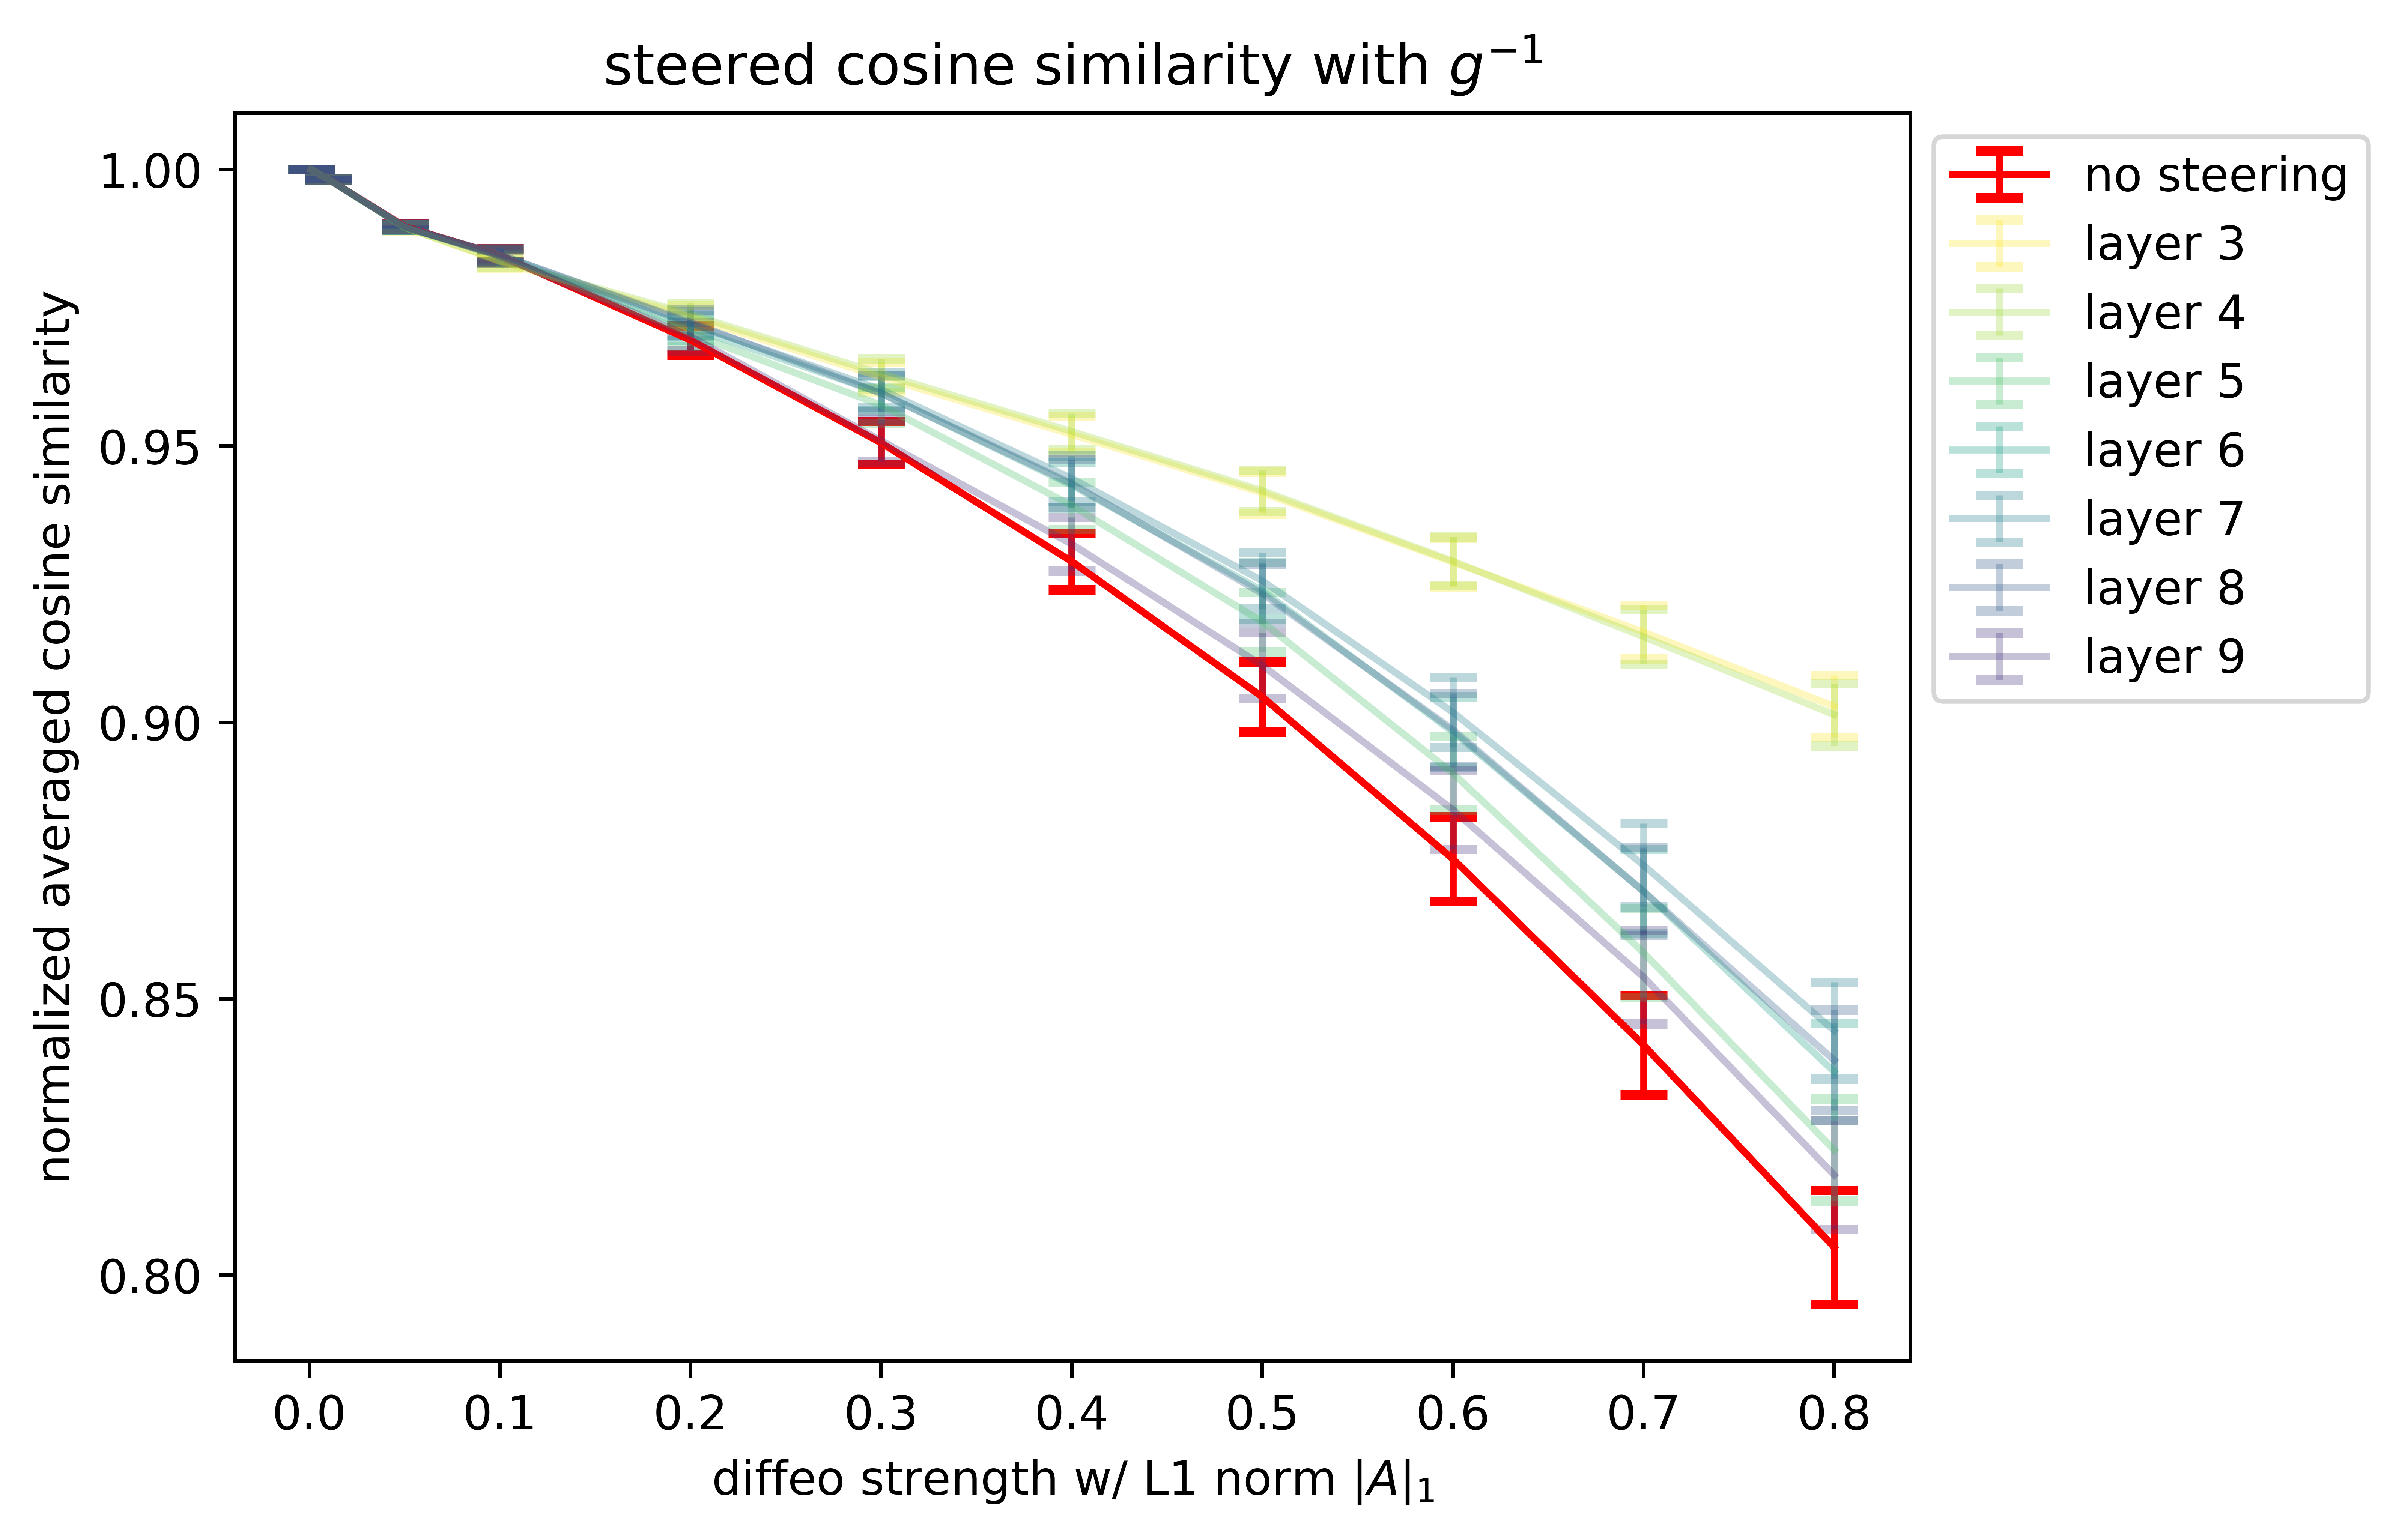

In [16]:
plt.figure(dpi = 900)

init_l = 3
init_l -= 2 #5
fin_l  = 9
fin_l -= 1 #4

init_A = 0
fin_A = 11

colors = plt.cm.viridis_r(np.linspace(0,1,1 + len(dot_product[init_l:fin_l])))

plt.errorbar(diffeo_strengths[init_A:fin_A], dot_product[0][init_A:fin_A], err_bar[0][init_A:fin_A]/20, color='r', label = f'no steering', alpha = 1, capsize= 5, capthick= 2)

for i, (layer, error) in enumerate(zip(dot_product[init_l:fin_l], err_bar[init_l:fin_l])):
    layer_num = init_l + 2 + i
    # if i == 0: layer_num = 0
    plt.errorbar(diffeo_strengths[init_A:fin_A], layer[init_A:fin_A], error[init_A:fin_A]/20, color=colors[i], label = f'layer {layer_num}', alpha = 0.3, capsize= 5, capthick= 2)
    # plt.hlines(y = 1, xmin = diffeo_strengths[init_A], xmax = diffeo_strengths[fin_A - 1], color = 'r', linestyle = '--')
    plt.legend(bbox_to_anchor=(1,1))
    plt.legend(bbox_to_anchor=(1,1), ncol=1)
    plt.xlabel(r'diffeo strength w/ L1 norm $|A|_1$')
    plt.title(r'steered cosine similarity with $g^{-1}$')
    plt.ylabel(r'normalized averaged cosine similarity')

